In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

In [17]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

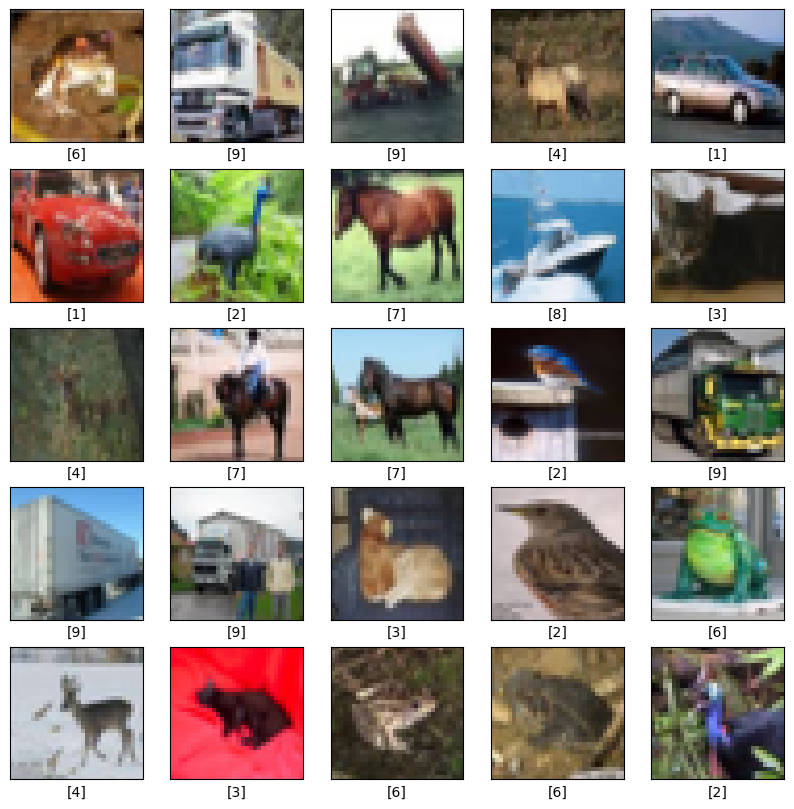

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [19]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [20]:
x_train = x_train.reshape((x_train.shape[0], 32, 32, -1))
x_test = x_test.reshape((x_test.shape[0], 32, 32, -1))

In [21]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [22]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


In [23]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

In [24]:
model.compile(
    optimizer = Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [10]:
model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/50


782/782 [==============================] - 268s 331ms/step - loss: 1.8197 - accuracy: 0.0957 - val_loss: 1.4727 - val_accuracy: 0.0623
Epoch 2/50
782/782 [==============================] - 246s 314ms/step - loss: 1.4382 - accuracy: 0.0925 - val_loss: 1.3114 - val_accuracy: 0.0745
Epoch 3/50
782/782 [==============================] - 249s 318ms/step - loss: 1.2498 - accuracy: 0.0984 - val_loss: 1.1557 - val_accuracy: 0.0709
Epoch 4/50
782/782 [==============================] - 247s 315ms/step - loss: 1.1230 - accuracy: 0.1002 - val_loss: 1.1112 - val_accuracy: 0.0992
Epoch 5/50
782/782 [==============================] - 242s 309ms/step - loss: 1.0440 - accuracy: 0.1009 - val_loss: 0.9814 - val_accuracy: 0.0687
Epoch 6/50
782/782 [==============================] - 237s 302ms/step - loss: 0.9723 - accuracy: 0.1012 - val_loss: 0.8194 - val_accuracy: 0.1448
Epoch 7/50
782/782 [==============================] - 191s 244ms/step - loss: 0.9260 - accuracy: 0.1021 - val_loss: 0.9384

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 11s - loss: 0.4267 - accuracy: 0.1033 - 11s/epoch - 36ms/step

Test accuracy: 0.10329999774694443


In [12]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [25]:
predictions = probability_model.predict((x_test * 255).astype("uint8"))

313/313 [==============================] - 19s 53ms/step


In [26]:
def plot_image(i, predictions_array, true_label, img):
    # Extract the true label (account for one-hot or integer)
    tl = true_label[i]

    # If label is one-hot encoded, convert to int
    if hasattr(tl, "__len__") and not isinstance(tl, (np.int64, int)):
        true_label_scalar = int(np.argmax(tl))
    else:
        true_label_scalar = int(tl)

    # Extract image
    image = img[i]

    # If image is (28,28,1), convert to (28,28)
    if image.ndim == 3 and image.shape[-1] == 1:
        image = image.reshape(28, 28)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap=plt.cm.binary)

    predicted_label = int(np.argmax(predictions_array))
    color = 'blue' if predicted_label == true_label_scalar else 'red'

    plt.xlabel(
        f"Pred: {predicted_label}  ({100*np.max(predictions_array):.0f}%)   True: {true_label_scalar}",
        color=color
    )
def plot_value_array(i, predictions_array, true_label):
    tl = true_label[i]

    # Convert one-hot label to integer
    if hasattr(tl, "__len__") and not isinstance(tl, (np.int64, int)):
        true_label_scalar = int(np.argmax(tl))
    else:
        true_label_scalar = int(tl)

    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    bars = plt.bar(range(10), predictions_array)

    predicted_label = int(np.argmax(predictions_array))

    bars[predicted_label].set_color('red')
    bars[true_label_scalar].set_color('blue')


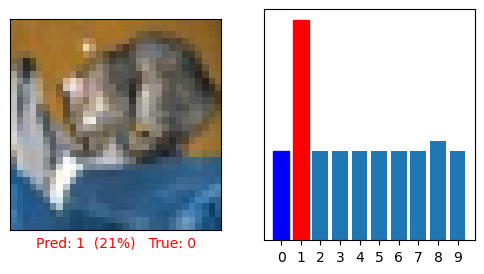

In [27]:
i = 0   # index of the test image you want to check

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plot_image(i, predictions[i], y_test, x_test)

plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], y_test)

plt.show()